## Exploration of the parameters for a good ensemble model

`grant_tagger.py` was run with all combinations of the following vectorizers and classifiers:

Vectorizer: 
1. Count
2. TF-IDF
3. BERT
4. SciBERT

Classifier: 
1. Naïve Bayes
2. SVM
3. Logistic regression

This outputted in **12 trained models**. We also have the predictions of each model on a test set.

Test each combination of models and the number that need to agree to find the best parameters for an ensemble model. This information can be put into a config file for use in `tech_grant_tagger.py` to make future predictions.



In [1]:
import json
import itertools
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score
)

In [2]:
cd ..

/Users/gallaghe/Code/nutrition-labels


## Load data

In [3]:
date_model_test ='210221'

In [4]:
# Test performance of each model
with open(f'data/processed/model_test_results/models_summary_{date_model_test}.jsonl') as f:
    model_results = json.load(f)
model_results = pd.DataFrame(model_results).T
model_results['model_name'] = ['_'.join(m.split('_')[0:-1]) for m in model_results.index]
model_results['Type'] = ['Original model']*len(model_results)
model_results

,f1,precision_score,recall_score,model_name,Type
bert_naive_bayes_bert_210221,0.746032,0.803419,0.696296,bert_naive_bayes_bert,Original model
bert_SVM_scibert_210221,0.782609,0.838983,0.733333,bert_SVM_scibert,Original model
count_SVM_210221,0.719665,0.826923,0.637037,count_SVM,Original model
tfidf_naive_bayes_210221,0.816901,0.778523,0.859259,tfidf_naive_bayes,Original model
bert_log_reg_bert_210221,0.789272,0.817460,0.762963,bert_log_reg_bert,Original model
tfidf_SVM_210221,0.736402,0.846154,0.651852,tfidf_SVM,Original model
bert_SVM_bert_210221,0.779923,0.814516,0.748148,bert_SVM_bert,Original model
bert_naive_bayes_scibert_210221,0.778626,0.803150,0.755556,bert_naive_bayes_scibert,Original model
count_log_reg_210221,0.772201,0.806452,0.740741,count_log_reg,Original model
count_naive_bayes_210221,0.773585,0.820000,0.732143,count_naive_bayes,Original model


In [20]:
# The test predictions for each model
model_predictions = pd.read_csv(f'data/processed/model_test_results/model_test_results_{date_model_test}.csv')
model_predictions.head(10)

,bert_naive_bayes_bert_210221,bert_SVM_scibert_210221,count_SVM_210221,tfidf_naive_bayes_210221,bert_log_reg_bert_210221,tfidf_SVM_210221,bert_SVM_bert_210221,bert_naive_bayes_scibert_210221,count_log_reg_210221,count_naive_bayes_210221,tfidf_log_reg_210221,bert_log_reg_scibert_210221,Internal ID
0,1,1,1,1,1,1,1,1,1,1,1,1,219603/Z/19/Z
1,1,0,0,0,0,0,0,1,0,1,0,0,219425/Z/19/Z
2,1,0,0,0,1,0,0,1,0,0,0,0,219420/Z/19/Z
3,1,0,0,0,0,0,0,1,0,0,0,0,219007/Z/19/Z
4,1,0,1,1,1,1,0,1,1,1,1,0,218880/Z/19/Z
5,1,1,1,1,1,1,1,1,1,1,1,1,218584/Z/19/Z
6,1,0,0,1,0,0,0,1,1,1,0,0,218539/Z/19/Z
7,1,1,0,0,1,0,0,1,0,0,0,0,218510/Z/19/Z
8,1,0,0,1,0,0,0,1,1,0,0,0,218369/Z/19/Z
9,1,0,0,1,0,0,0,1,1,0,0,0,218358/Z/19/Z


In [6]:
# Merge the model test predictions with the actual test values
test_data = pd.read_csv(f'data/processed/model_test_results/test_data_{date_model_test}.csv')
model_predictions = pd.merge( 
    model_predictions,
    test_data[['Internal ID', 'Relevance code']],
    how = 'left',
    on = ['Internal ID']
    )

## Visualise the precision/recall for each model

In [7]:
min_precision = model_results['precision_score'].min()
max_precision = model_results['precision_score'].max()
print((min_precision, max_precision))

min_recall = model_results['recall_score'].min()
max_recall = model_results['recall_score'].max()
print((min_recall, max_recall))

min_both = min(min_precision, min_recall)-0.05
max_both = min(max_precision, max_recall)+0.05

(0.7785234899328859, 0.8461538461538461)
(0.6370370370370371, 0.8592592592592593)


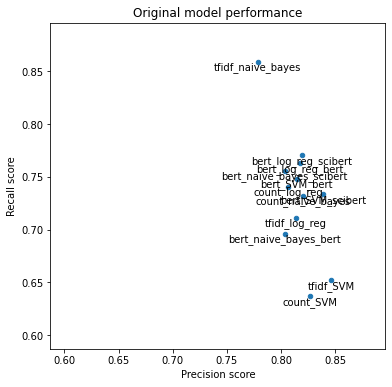

In [8]:
fig, ax = plt.subplots()
ax = model_results.plot(
    'precision_score',
    'recall_score',
    figsize=(6,6),
    kind='scatter',
    xlim=(min_both,max_both),
    ylim=(min_both,max_both),
    ax=ax)

ax.set(xlabel='Precision score', ylabel='Recall score', 
       title='Original model performance')
    
for k, v in model_results.iterrows():
    ax.text(
        v['precision_score'],
        v['recall_score'],
        str(v['model_name']),
        horizontalalignment='center',
        verticalalignment='top'
        )

## Test ensemble models using all combinations of models

In [9]:
# Get every combination of models
models_list = model_results.index.tolist()
all_combinations = []
for r in range(2, len(models_list) + 1):
    combinations_object = itertools.combinations(models_list, r)
    combinations_list = list(combinations_object)
    all_combinations += combinations_list
len(all_combinations)

4083

In [10]:
# Find the test performance for each model combition and number of models that need to agree
labels = model_predictions['Relevance code']

average_type = 'binary'
all_combos_scores = []
for i, model_combination in enumerate(all_combinations):
    if i%1000==0:
        print(i)
    # How many of the models agree on tech grant prediction?
    prediction_sums = model_predictions[list(model_combination)].sum(axis=1)
    for num_agree in range(1, len(model_combination)):
        # Calculate test metrics
        y_pred = [1 if pred_sum >= num_agree else 0 for pred_sum in prediction_sums]
        all_combos_scores.append({
            'Type': 'Ensemble model',
            'model_name': model_combination,
            'num_models': len(model_combination),
            'num_agree': num_agree,
            'f1': f1_score(labels, y_pred, average=average_type),
            'precision_score': precision_score(labels, y_pred, zero_division=0, average=average_type),
            'recall_score': recall_score(labels, y_pred, zero_division=0, average=average_type)
            })
all_combos_scores_df = pd.DataFrame(all_combos_scores)

0
1000
2000
3000
4000


In [17]:
# axis_lims = (0.5, 1.05)
# all_combos_scores_df.plot.scatter(
#     'precision_score',
#     'recall_score',
#     figsize=(10,8),
#     c='num_agree',
#     colormap="winter",
#     sharex=False,
#     xlim=axis_lims,
#     ylim=axis_lims,
#     title='Ensemble model performance',
#     xlabel='Precision score',
#     ylabel='Recall score'
# );

### Plot ensemble results with original single model results

In [11]:
combined_results = pd.concat([model_results, all_combos_scores_df])

In [12]:
# We want to colour original models by vectoriser used, so set up a colour column for this
vects = ['scibert', 'count', 'tfidf']
model_vect = []
for _, row in combined_results.iterrows():
    if row['Type']== 'Ensemble model':
        model_vect.append('ensemble')
    else:
        which_vect = [i for i in vects if i in row['model_name']]
        if len(which_vect)==0:
            model_vect.append('bert')
        else:
            model_vect.append(which_vect[0])
    
combined_results['Vectorizer type'] = model_vect
colour_map = {'scibert': 'green', 'bert': 'blue', 'count': 'red', 'tfidf': 'orange', 'ensemble': 'black'}
combined_results['Vectorizer type colour'] = [colour_map[c] for c in combined_results['Vectorizer type']]

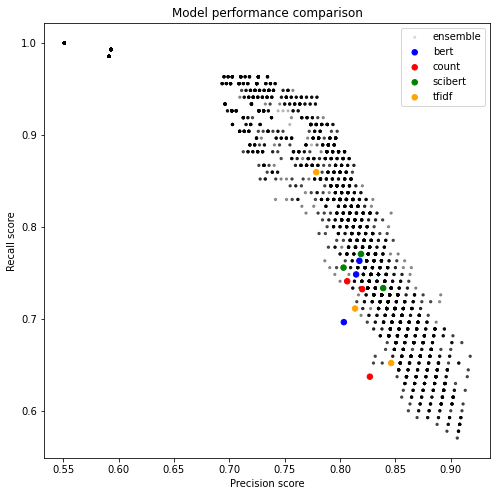

In [13]:
vectorizer_groups = combined_results.groupby('Vectorizer type')

# Plot the ensemble results first since there are so many
group_names = list(vectorizer_groups.groups.keys())
group_names.remove('ensemble')
group_order = ['ensemble'] + group_names

fig, ax = plt.subplots(1, figsize=(8,8))

for label in group_order:
    if label == 'ensemble':
        alpha = 0.1
        size = 5
    else:
        alpha = 1
        size = 30
    group = vectorizer_groups.get_group(label)
    ax.scatter(
        group['precision_score'],
        group['recall_score'],
        c=group['Vectorizer type colour'],
        label=label,
        alpha=alpha,
        s=size
    )

ax.set(xlabel='Precision score', ylabel='Recall score', 
       title='Model performance comparison')
ax.legend()
# plt.axvline(0.8, color='k');
# plt.axhline(0.8, color='k');

plt.show()

## The highest performing ensemble models

In [14]:
precision_threshold = 0.84
recall_threshold = 0.81

In [15]:
best_results = all_combos_scores_df.loc[
    (
        (all_combos_scores_df['precision_score'] >= precision_threshold) & 
        (all_combos_scores_df['recall_score'] >= recall_threshold)
    )
]
best_results

,Type,model_name,num_models,num_agree,f1,precision_score,recall_score
411,Ensemble model,"(bert_log_reg_bert_210221, bert_SVM_bert_21022...",3,2,0.830189,0.846154,0.814815
859,Ensemble model,"(bert_naive_bayes_bert_210221, bert_log_reg_be...",4,3,0.830189,0.846154,0.814815
1831,Ensemble model,"(bert_log_reg_bert_210221, bert_SVM_bert_21022...",4,3,0.830189,0.846154,0.814815
3098,Ensemble model,"(bert_naive_bayes_bert_210221, bert_log_reg_be...",5,4,0.830189,0.846154,0.814815


In [16]:
# Less models to have to make predictions from the better
optimal_model_i = 411
num_agree = best_results.loc[optimal_model_i]['num_agree']
model_combination = list(best_results.loc[optimal_model_i]['model_name'])
model_combination

['bert_log_reg_bert_210221',
 'bert_SVM_bert_210221',
 'count_naive_bayes_210221']

In [17]:
prediction_sums = model_predictions[list(model_combination)].sum(axis=1)
y_pred = [1 if pred_sum >= num_agree else 0 for pred_sum in prediction_sums]

In [18]:
print(classification_report(labels, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.82      0.80       110
           1       0.85      0.81      0.83       135

    accuracy                           0.82       245
   macro avg       0.81      0.82      0.82       245
weighted avg       0.82      0.82      0.82       245



In [19]:
print(confusion_matrix(labels, y_pred))

[[ 90  20]
 [ 25 110]]
